In [ ]:
import tensorflow as tf

In [ ]:
class Precision(tf.keras.metrics.Metric):
    def __init__(self, num_classes, **kwargs):
        super(Precision, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.precision = self.add_weight(name='precision', shape=(num_classes,), initializer='zeros', dtype=tf.float32)
        self.true_positives = [self.add_weight(name='true_positives_{}'.format(i), shape=(), initializer='zeros', dtype=tf.float32) for i in range(num_classes)]
        self.false_positives = [self.add_weight(name='false_positives_{}'.format(i), shape=(), initializer='zeros', dtype=tf.float32) for i in range(num_classes)]
    @tf.autograph.experimental.do_not_convert
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        
        for i in range(self.num_classes):
            true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, i), tf.equal(y_pred, i)), tf.float32))
            false_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.not_equal(y_true, i), tf.equal(y_pred, i)), tf.float32))
            self.true_positives[i].assign_add(true_positives)
            self.false_positives[i].assign_add(false_positives)
            denominator = self.true_positives[i] + self.false_positives[i]
            precision = tf.where(tf.equal(denominator, 0), 0.0, self.true_positives[i] / denominator)
            self.precision[i].assign(precision)

    def result(self):
        macro_precision = tf.reduce_mean(self.precision)
        return macro_precision

    def reset_state(self):
        self.precision.assign(tf.zeros(shape=(self.num_classes,), dtype=tf.float32))
        for i in range(self.num_classes):
            self.true_positives[i].assign(tf.zeros(shape=(), dtype=tf.float32))
            self.false_positives[i].assign(tf.zeros(shape=(), dtype=tf.float32))


In [ ]:
class Recall(tf.keras.metrics.Metric):
    def __init__(self, num_classes, **kwargs):
        super(Recall, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.recall = self.add_weight(name='recall', shape=(num_classes,), initializer='zeros', dtype=tf.float32)
        self.true_positives = [self.add_weight(name='true_positives_{}'.format(i), shape=(), initializer='zeros', dtype=tf.float32) for i in range(num_classes)]
        self.false_negatives = [self.add_weight(name='false_negatives_{}'.format(i), shape=(), initializer='zeros', dtype=tf.float32) for i in range(num_classes)]

    @tf.autograph.experimental.do_not_convert
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)

        for i in range(self.num_classes):
            true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, i), tf.equal(y_pred, i)), tf.float32))
            false_negatives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, i), tf.not_equal(y_pred, i)), tf.float32))
            self.true_positives[i].assign_add(tf.cast(true_positives, tf.float32))
            self.false_negatives[i].assign_add(tf.cast(false_negatives, tf.float32))
            denominator = self.true_positives[i] + self.false_negatives[i]
            recall = tf.where(tf.equal(denominator, 0), 0.0, self.true_positives[i] / denominator)
            self.recall[i].assign(recall)

    def result(self):
        macro_recall = tf.reduce_mean(self.recall)
        return macro_recall

    def reset_state(self):
        self.recall.assign(tf.zeros(shape=(self.num_classes,), dtype=tf.float32))
        for i in range(self.num_classes):
            self.true_positives[i].assign(tf.zeros(shape=(), dtype=tf.float32))
            self.false_negatives[i].assign(tf.zeros(shape=(), dtype=tf.float32))


In [ ]:
class WeightedAccuracy(tf.keras.metrics.Metric):
    def __init__(self, num_classes, class_weights, **kwargs):
        super(WeightedAccuracy, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.class_weights = class_weights
        self.weighted_accuracy = self.add_weight(name='weighted_accuracy', shape=(), initializer='zeros', dtype=tf.float32)
        self.total_samples = self.add_weight(name='total_samples', shape=(), initializer='zeros', dtype=tf.float32)
        self.true_positives = [self.add_weight(name='true_positives_{}'.format(i), shape=(), initializer='zeros', dtype=tf.float32) for i in range(num_classes)]
        self.false_positives = [self.add_weight(name='false_positives_{}'.format(i), shape=(), initializer='zeros', dtype=tf.float32) for i in range(num_classes)]
        self.false_negatives = [self.add_weight(name='false_negatives_{}'.format(i), shape=(), initializer='zeros', dtype=tf.float32) for i in range(num_classes)]
    @tf.autograph.experimental.do_not_convert
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        if sample_weight is None:
            sample_weight = tf.ones_like(y_true, dtype=tf.float32)
        else:
            sample_weight = tf.cast(sample_weight, dtype=tf.float32)
    
        for i in range(self.num_classes):
            y_true_i = tf.equal(y_true, i)
            y_pred_i = tf.equal(y_pred, i)
            true_positives = tf.math.count_nonzero(tf.logical_and(y_true_i, y_pred_i), dtype=tf.float32) * sample_weight * self.class_weights[i]
            false_positives = tf.math.count_nonzero(tf.logical_and(tf.logical_not(y_true_i), y_pred_i), dtype=tf.float32) * sample_weight * self.class_weights[i]
            false_negatives = tf.math.count_nonzero(tf.logical_and(y_true_i, tf.logical_not(y_pred_i)), dtype=tf.float32) * sample_weight * self.class_weights[i]
            self.true_positives[i].assign_add(tf.reduce_sum(true_positives))
            self.false_positives[i].assign_add(tf.reduce_sum(false_positives))
            self.false_negatives[i].assign_add(tf.reduce_sum(false_negatives))
        
        self.total_samples.assign_add(tf.reduce_sum(sample_weight))

In [ ]:
 def result(self):
        if self.class_weights is None:
            return 0
        weighted_accuracies = [tp / (tp + fn + 1e-10) for tp, fn in zip(self.true_positives, self.false_negatives)]
        self.weighted_accuracy.assign(tf.reduce_sum([wa * cw for wa, cw in zip(weighted_accuracies, self.class_weights)]) / tf.reduce_sum(self.class_weights))
        return self.weighted_accuracy

## CNN

### without preprocessing

Loading classes: 100%|██████████| 4/4 [00:30<00:00,  7.71s/it]                 
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training model: 100%|██████████| 20/20 [02:13<00:00,  6.66s/it, train_loss=0.0554, val_loss=1.05, accuracy=0.978, val_accuracy=0.848] 


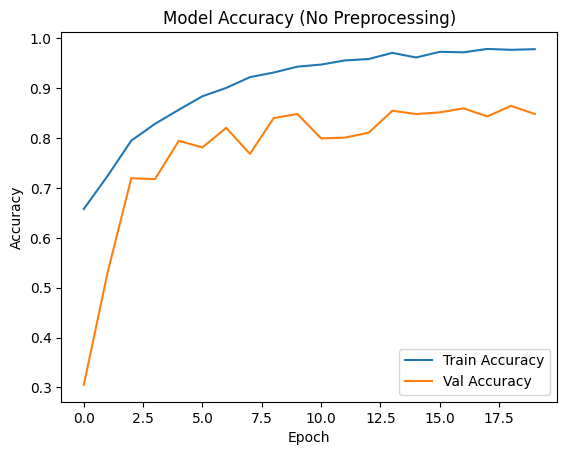

Final Train Accuracy: 97.83%
Final Validation Accuracy: 84.83%
Test Accuracy without preprocessing: 49.61%


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
img_height, img_width = 150, 150
batch_size = 32
num_classes = 4  
epochs = 20

# Load images and labels with tqdm for progress tracking
def load_images_from_folder(folder):
    images = []
    labels = []
    label_dict = {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}
    for label in tqdm(label_dict.keys(), desc="Loading classes"):
        class_folder = os.path.join(folder, label)
        for filename in tqdm(os.listdir(class_folder), desc=f"Loading images for {label}", leave=False):
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (img_height, img_width))
                images.append(img)
                labels.append(label_dict[label])
    return np.array(images), np.array(labels)

# Define folders
train_folder = '/kaggle/input/oct-multiclass-analysis-4-class/Dataset - train+val+test/train'
val_folder = '/kaggle/input/oct-multiclass-analysis-4-class/Dataset - train+val+test/val'
test_folder = '/kaggle/input/oct-multiclass-analysis-4-class/Dataset - train+val+test/test'

# Load data
X_train, y_train = load_images_from_folder(train_folder)
X_val, y_val = load_images_from_folder(val_folder)
X_test, y_test = load_images_from_folder(test_folder)

# Normalize images
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Convert labels to categorical (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# CNN Model
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate the model with tqdm for progress tracking
def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test):
    model = create_cnn_model()
    with tqdm(total=epochs, desc="Training model") as pbar:
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[tqdmCallback(pbar)])
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    return model, history, test_accuracy

# Custom tqdm callback for model training
class tqdmCallback(tf.keras.callbacks.Callback):
    def __init__(self, pbar):
        self.pbar = pbar

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        self.pbar.set_postfix({
            "train_loss": logs.get('loss'), 
            "val_loss": logs.get('val_loss'), 
            "accuracy": logs.get('accuracy'), 
            "val_accuracy": logs.get('val_accuracy')
        })

# Function to store results in CSV
def save_results_to_csv(history, test_acc, filename):
    df = pd.DataFrame(history.history)
    df['test_accuracy'] = [test_acc] * len(df)  # Store test accuracy across all epochs
    df.to_csv(filename, index=False)

# Train and evaluate without preprocessing
model, history_no_preprocess, test_acc_no_preprocess = train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test)
save_results_to_csv(history_no_preprocess, test_acc_no_preprocess, 'CSV_results_no_preprocessing.csv')

# Save the model
model.save("cnn_model_no_preprocessing.h5")

# Plot the training and validation accuracy
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy (No Preprocessing)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

# Plot accuracy for model without preprocessing
plot_accuracy(history_no_preprocess)

# Final accuracy results
final_train_accuracy = history_no_preprocess.history['accuracy'][-1]
final_val_accuracy = history_no_preprocess.history['val_accuracy'][-1]
print(f"Final Train Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")
print(f"Test Accuracy without preprocessing: {test_acc_no_preprocess * 100:.2f}%")



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.6382 - loss: 1.0630 - val_accuracy: 0.2871 - val_loss: 1.4131
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7065 - loss: 0.7870 - val_accuracy: 0.4959 - val_loss: 1.2231
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7615 - loss: 0.6349 - val_accuracy: 0.6036 - val_loss: 1.0122
Epoch 4/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8066 - loss: 0.5133 - val_accuracy: 0.6378 - val_loss: 0.8774
Epoch 5/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8466 - loss: 0.4152 - val_accuracy: 0.7423 - val_loss: 0.7665
Epoch 6/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8678 - loss: 0.3499 - val_accuracy: 0.7781 - val_loss: 0.7030
Epoch 7/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8827 - loss: 0.2973 - val_accuracy: 0.7178 - val_loss: 0.9514
Epoch 8/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9063 - loss: 0.2516 - val_acc

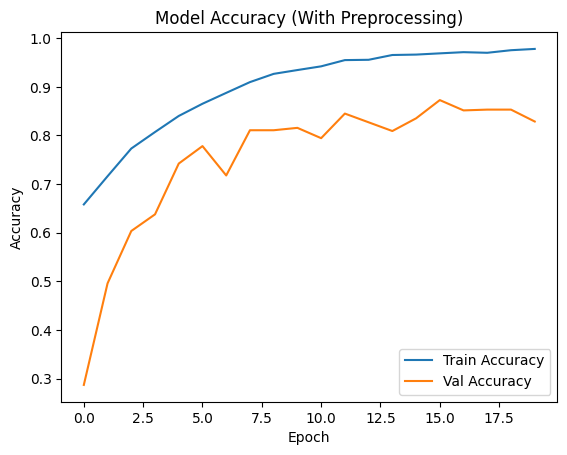

Final Train Accuracy: 97.80%
Final Validation Accuracy: 82.87%
Test Accuracy with preprocessing: 46.22%


In [5]:
# Constants
img_height, img_width = 150, 150
batch_size = 32
num_classes = 4
epochs = 20

# Create directory for saving processed images
processed_img_dir = 'processed_images'
if not os.path.exists(processed_img_dir):
    os.makedirs(processed_img_dir)

# Load and preprocess images
def load_and_preprocess_images(folder, save_dir, preprocess=False):
    images = []
    labels = []
    label_dict = {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}
    for label in label_dict.keys():
        class_folder = os.path.join(folder, label)
        for i, filename in enumerate(os.listdir(class_folder)):
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (img_height, img_width))

                # Apply preprocessing (Grayscale + Gaussian blur)
                if preprocess:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.GaussianBlur(img, (5, 5), 0)
                    img = cv2.merge([img, img, img])  # Convert back to 3 channels

                # Save processed image
                cv2.imwrite(f'{save_dir}/{label}_image_{i}.png', img)
                images.append(img)
                labels.append(label_dict[label])
    return np.array(images), np.array(labels)

# Define folders
train_folder = '/kaggle/input/oct-multiclass-analysis-4-class/Dataset - train+val+test/train'
val_folder = '/kaggle/input/oct-multiclass-analysis-4-class/Dataset - train+val+test/val'
test_folder = '/kaggle/input/oct-multiclass-analysis-4-class/Dataset - train+val+test/test'

# Preprocess and load data
X_train_preprocessed, y_train_preprocessed = load_and_preprocess_images(train_folder, os.path.join(processed_img_dir, 'train'), preprocess=True)
X_val_preprocessed, y_val_preprocessed = load_and_preprocess_images(val_folder, os.path.join(processed_img_dir, 'val'), preprocess=True)
X_test_preprocessed, y_test_preprocessed = load_and_preprocess_images(test_folder, os.path.join(processed_img_dir, 'test'), preprocess=True)

# Normalize images
X_train_preprocessed = X_train_preprocessed / 255.0
X_val_preprocessed = X_val_preprocessed / 255.0
X_test_preprocessed = X_test_preprocessed / 255.0

# Convert labels to categorical (one-hot encoding)
y_train_preprocessed = tf.keras.utils.to_categorical(y_train_preprocessed, num_classes)
y_val_preprocessed = tf.keras.utils.to_categorical(y_val_preprocessed, num_classes)
y_test_preprocessed = tf.keras.utils.to_categorical(y_test_preprocessed, num_classes)

# CNN Model
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate the model
def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test):
    model = create_cnn_model()
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    return model, history, test_accuracy

# Function to store results in CSV
def save_results_to_csv(history, test_acc, filename):
    df = pd.DataFrame(history.history)
    df['test_accuracy'] = [test_acc] * len(df)  # Store test accuracy across all epochs
    df.to_csv(filename, index=False)

# Train and evaluate with preprocessing
model_preprocess, history_preprocess, test_acc_preprocess = train_and_evaluate(
    X_train_preprocessed, y_train_preprocessed, X_val_preprocessed, y_val_preprocessed, X_test_preprocessed, y_test_preprocessed
)
save_results_to_csv(history_preprocess, test_acc_preprocess, 'CSV_results_with_preprocessing.csv')

# Save the model
model_preprocess.save("cnn_model_with_preprocessing.h5")

# Plot the training and validation accuracy
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy (With Preprocessing)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

# Plot accuracy for model with preprocessing
plot_accuracy(history_preprocess)

# Print final train, validation, and test accuracy
final_train_accuracy = history_preprocess.history['accuracy'][-1]
final_val_accuracy = history_preprocess.history['val_accuracy'][-1]
print(f'Final Train Accuracy: {final_train_accuracy * 100:.2f}%')
print(f'Final Validation Accuracy: {final_val_accuracy * 100:.2f}%')
print(f'Test Accuracy with preprocessing: {test_acc_preprocess * 100:.2f}%')


# vgg16

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import os
from sklearn.utils.class_weight import compute_class_weight




In [9]:
# Constants
IMG_HEIGHT, IMG_WIDTH = 224, 224  # Required input size for VGG16
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 20
LEARNING_RATE = 1e-4



In [10]:
# Directories for data
TRAIN_DIR = '/kaggle/input/oct-multiclass-analysis-4-class/Dataset - train+val+test/train'
VAL_DIR = '/kaggle/input/oct-multiclass-analysis-4-class/Dataset - train+val+test/val'
TEST_DIR = '/kaggle/input/oct-multiclass-analysis-4-class/Dataset - train+val+test/test'
SAVED_MODEL_PATH = '/kaggle/working/vgg16_best_model.keras'



In [11]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)



In [12]:
# Data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)



Found 9439 images belonging to 4 classes.
Found 613 images belonging to 4 classes.
Found 7377 images belonging to 4 classes.


In [13]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))



In [14]:
# Load VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model layers
base_model.trainable = True
for layer in base_model.layers[:-4]:  # Freeze all layers except the last 4
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [16]:
# # Callbacks
# callbacks = [
#     ModelCheckpoint(SAVED_MODEL_PATH, monitor='val_loss', save_best_only=True, verbose=1),
#     EarlyStopping(monitor='val_loss', patience=5, verbose=1)
# ]



In [17]:
# # Train the model
# history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=EPOCHS,
#     callbacks=callbacks,
#     verbose=1
# )

class_weights_dict = dict(enumerate(compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)))

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=[ModelCheckpoint(SAVED_MODEL_PATH, save_best_only=True), EarlyStopping()]
)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732653374.453030     210 service.cc:145] XLA service 0x7be9140092d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732653374.453084     210 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732653374.453089     210 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/295 ━━━━━━━━━━━━━━━━━━━━ 2:01:54 25s/step - accuracy: 0.2500 - loss: 1.7519

I0000 00:00:1732653391.868852     210 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


295/295 ━━━━━━━━━━━━━━━━━━━━ 224s 677ms/step - accuracy: 0.2125 - loss: 1.7185 - val_accuracy: 0.6966 - val_loss: 1.1130
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 135s 447ms/step - accuracy: 0.3582 - loss: 1.0680 - val_accuracy: 0.7847 - val_loss: 0.6013
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 134s 444ms/step - accuracy: 0.4873 - loss: 0.7883 - val_accuracy: 0.8401 - val_loss: 0.4245
Epoch 4/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 135s 446ms/step - accuracy: 0.5979 - loss: 0.6566 - val_accuracy: 0.8825 - val_loss: 0.3461
Epoch 5/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 134s 444ms/step - accuracy: 0.7007 - loss: 0.5240 - val_accuracy: 0.8662 - val_loss: 0.3794


In [18]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Classification report
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=-1)
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))



231/231 ━━━━━━━━━━━━━━━━━━━━ 65s 283ms/step - accuracy: 0.8736 - loss: 0.3678
Test Accuracy: 90.59%
231/231 ━━━━━━━━━━━━━━━━━━━━ 35s 149ms/step

Classification Report:
              precision    recall  f1-score   support

         CNV       0.67      0.93      0.78       190
         DME       0.81      0.86      0.84      1161
      DRUSEN       0.88      0.70      0.78       887
      NORMAL       0.94      0.95      0.95      5139

    accuracy                           0.91      7377
   macro avg       0.83      0.86      0.84      7377
weighted avg       0.91      0.91      0.91      7377



In [19]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)




Confusion Matrix:
[[ 177    7    5    1]
 [  27 1002   27  105]
 [  50   31  622  184]
 [  10  196   51 4882]]


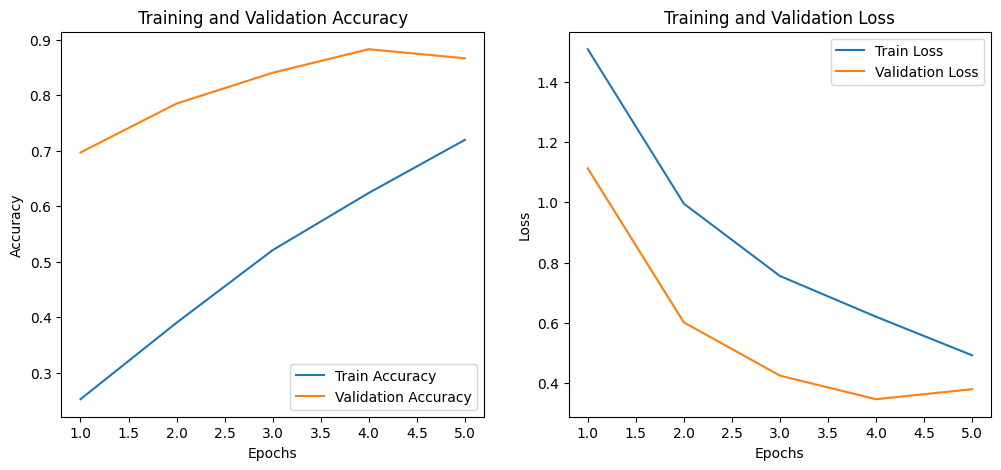

In [20]:
# Plot training accuracy and loss
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training(history)



In [21]:
# Save final model
model.save(SAVED_MODEL_PATH)
print(f"Model saved to {SAVED_MODEL_PATH}")

Model saved to /kaggle/working/vgg16_best_model.keras


## biletral filtering check 

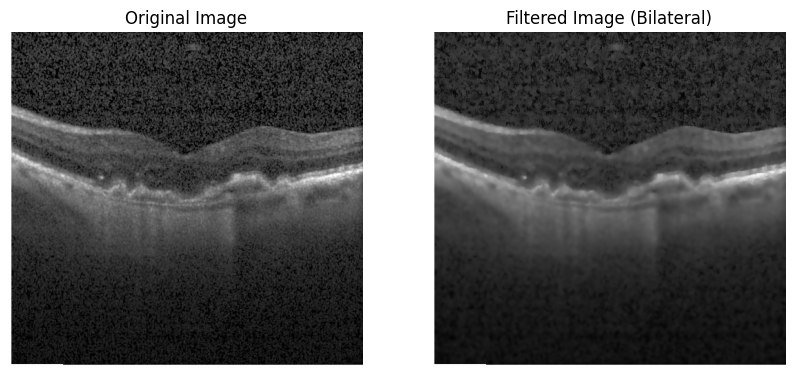

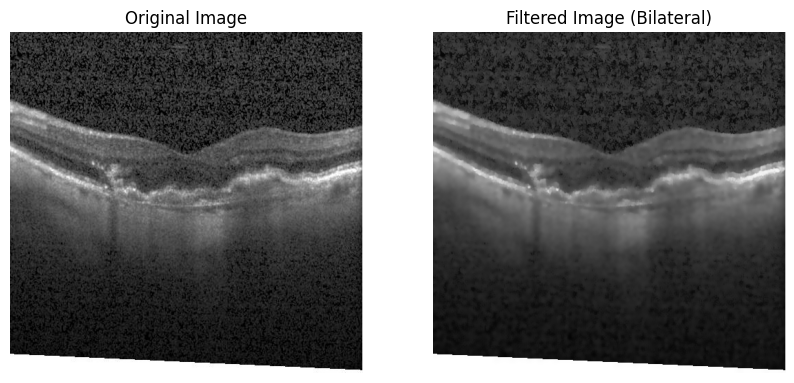

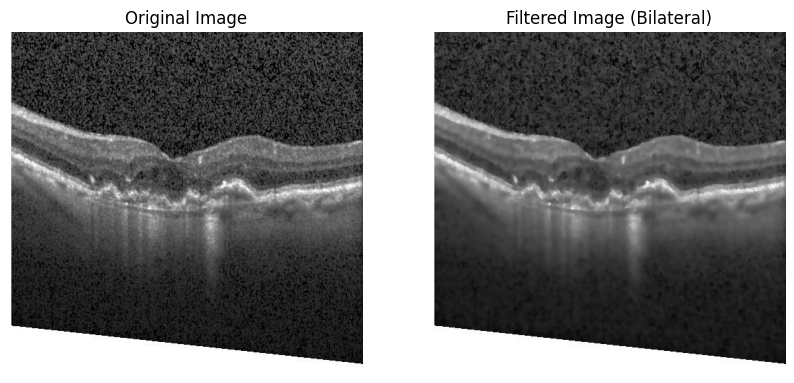

In [22]:
import cv2
import os
import matplotlib.pyplot as plt

def apply_bilateral_filter(image_path, d=9, sigma_color=75, sigma_space=75):
    """
    Applies bilateral filtering to an image.
    
    Args:
        image_path (str): Path to the input image.
        d (int): Diameter of each pixel neighborhood.
        sigma_color (float): Filter sigma in color space.
        sigma_space (float): Filter sigma in coordinate space.

    Returns:
        original_img (ndarray): Original image.
        filtered_img (ndarray): Bilateral filtered image.
    """
    # Read the image
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise ValueError(f"Could not read the image at {image_path}")
    
    # Convert to RGB for visualization (OpenCV reads BGR by default)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # Apply bilateral filter
    filtered_img = cv2.bilateralFilter(original_img, d=d, sigmaColor=sigma_color, sigmaSpace=sigma_space)
    
    return original_img, filtered_img

def visualize_results(image_paths, d=9, sigma_color=75, sigma_space=75):
    """
    Visualizes original and bilateral-filtered images side by side.
    
    Args:
        image_paths (list): List of image file paths to process.
        d, sigma_color, sigma_space: Parameters for bilateral filtering.
    """
    for image_path in image_paths:
        try:
            # Apply bilateral filter
            original, filtered = apply_bilateral_filter(image_path, d, sigma_color, sigma_space)
            
            # Plot original and filtered images
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(original)
            plt.title("Original Image")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(filtered)
            plt.title("Filtered Image (Bilateral)")
            plt.axis('off')

            plt.show()

        except Exception as e:
            print(f"Error processing {image_path}: {e}")

# Sample usage
sample_images = [
    '/kaggle/input/oct-multiclass-analysis-4-class/Dataset - train+val+test/test/CNV/CNV-103044-100.jpeg',
    '/kaggle/input/oct-multiclass-analysis-4-class/Dataset - train+val+test/test/CNV/CNV-103044-105.jpeg',
    '/kaggle/input/oct-multiclass-analysis-4-class/Dataset - train+val+test/test/CNV/CNV-103044-121.jpeg'
]

# Visualize bilateral filtering
visualize_results(sample_images, d=9, sigma_color=75, sigma_space=75)


## nonlocal means deniosing

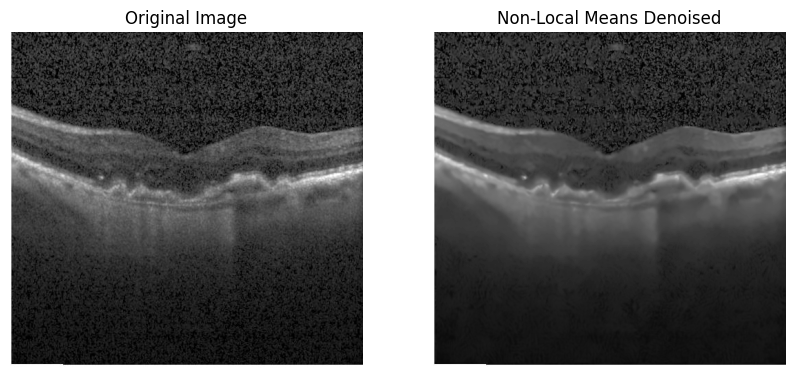

In [23]:
def apply_non_local_means(image_path, h=10, template_window_size=7, search_window_size=21):
    """
    Applies Non-Local Means Denoising to an image.
    
    Args:
        image_path (str): Path to the input image.
        h (float): Filtering strength. Higher values remove more noise but may lose details.
        template_window_size (int): Size of the template patch.
        search_window_size (int): Size of the window used for searching similar patches.
    
    Returns:
        original_img (ndarray): Original image.
        denoised_img (ndarray): Non-Local Means denoised image.
    """
    # Read the image
    original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if original_img is None:
        raise ValueError(f"Could not read the image at {image_path}")
    
    # Apply Non-Local Means Denoising
    denoised_img = cv2.fastNlMeansDenoising(original_img, None, h, template_window_size, search_window_size)
    
    return original_img, denoised_img

# Visualize Non-Local Means results
def visualize_non_local_means(image_path):
    original, denoised = apply_non_local_means(image_path)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(denoised, cmap='gray')
    plt.title("Non-Local Means Denoised")
    plt.axis('off')

    plt.show()

# Example usage
sample_image_path = '/kaggle/input/oct-multiclass-analysis-4-class/Dataset - train+val+test/test/CNV/CNV-103044-100.jpeg'
visualize_non_local_means(sample_image_path)


## combine bilateral filtering with contrast enhancement

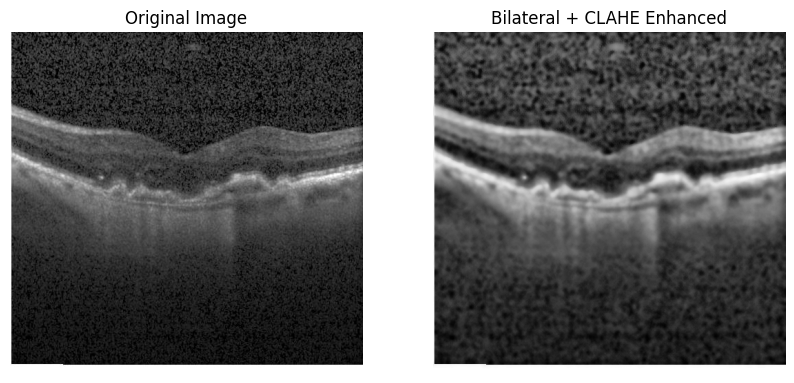

In [24]:
def bilateral_with_clahe(image_path, d=9, sigma_color=75, sigma_space=75, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Applies Bilateral Filtering followed by CLAHE.
    
    Args:
        image_path (str): Path to the input image.
        d, sigma_color, sigma_space: Parameters for bilateral filtering.
        clip_limit (float): Threshold for contrast clipping.
        tile_grid_size (tuple): Grid size for CLAHE.

    Returns:
        original_img (ndarray): Original image.
        enhanced_img (ndarray): Enhanced image after bilateral and CLAHE.
    """
    # Read and preprocess image
    original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if original_img is None:
        raise ValueError(f"Could not read the image at {image_path}")
    
    # Apply Bilateral Filter
    bilateral_filtered = cv2.bilateralFilter(original_img, d, sigma_color, sigma_space)
    
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced_img = clahe.apply(bilateral_filtered)
    
    return original_img, enhanced_img

# Visualize Bilateral + CLAHE
def visualize_bilateral_clahe(image_path):
    original, enhanced = bilateral_with_clahe(image_path)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(enhanced, cmap='gray')
    plt.title("Bilateral + CLAHE Enhanced")
    plt.axis('off')

    plt.show()

# Example usage
sample_image_path = '/kaggle/input/oct-multiclass-analysis-4-class/Dataset - train+val+test/test/CNV/CNV-103044-100.jpeg'
visualize_bilateral_clahe(sample_image_path)


## preprocessing 

### white border 

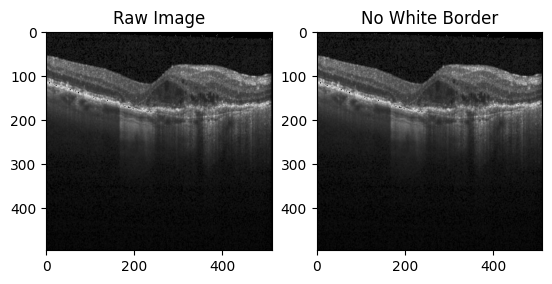

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def remove_white_border(image):
    """Replace white borders with black pixels."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    mask = binary == 255
    image[mask] = 0  # Set white pixels to black
    return image

# Test on a sample image
image = cv2.imread('/kaggle/input/oct-multiclass-analysis-4-class/Dataset - train+val+test/train/CNV/CNV-103044-10.jpeg')  # Replace with your image path
image_no_border = remove_white_border(image)

# Display result
plt.subplot(1, 2, 1)
plt.title("Raw Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("No White Border")
plt.imshow(cv2.cvtColor(image_no_border, cv2.COLOR_BGR2RGB))

plt.show()


### Non-Local Means Filter

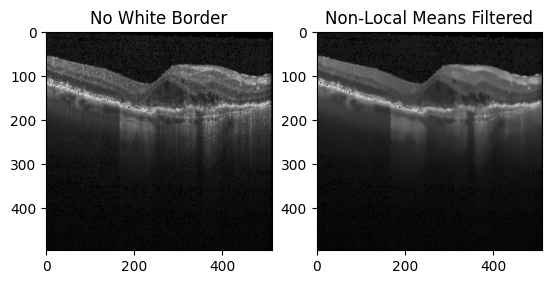

In [26]:
def apply_non_local_means_filter(image):
    """Denoise using non-local means filter."""
    filtered_image = cv2.fastNlMeansDenoisingColored(image, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)
    return filtered_image

# Apply filter
image_filtered = apply_non_local_means_filter(image_no_border)

# Display result
plt.subplot(1, 2, 1)
plt.title("No White Border")
plt.imshow(cv2.cvtColor(image_no_border, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Non-Local Means Filtered")
plt.imshow(cv2.cvtColor(image_filtered, cv2.COLOR_BGR2RGB))

plt.show()


### Otsu Thresholding

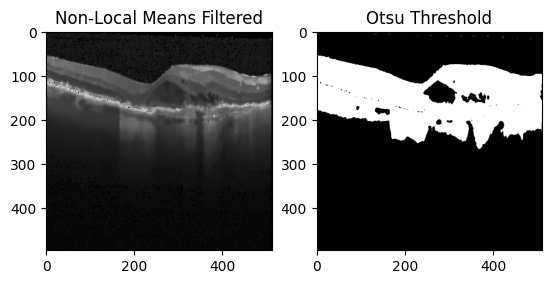

In [27]:
def apply_otsu_threshold(image):
    """Apply Otsu thresholding."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, otsu_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return otsu_image

# Apply Otsu threshold
image_otsu = apply_otsu_threshold(image_filtered)

# Display result
plt.subplot(1, 2, 1)
plt.title("Non-Local Means Filtered")
plt.imshow(cv2.cvtColor(image_filtered, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Otsu Threshold")
plt.imshow(image_otsu, cmap='gray')

plt.show()


### median filter

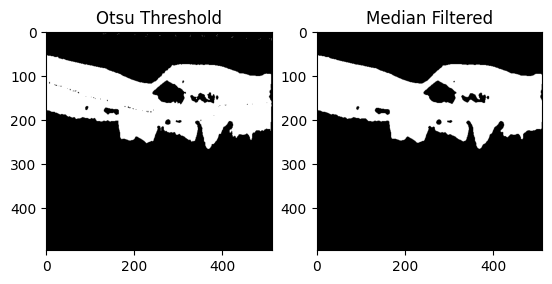

In [28]:
def apply_median_filter(image):
    """Apply median filter."""
    median_filtered_image = cv2.medianBlur(image, 5)
    return median_filtered_image

# Apply median filter
image_median = apply_median_filter(image_otsu)

# Display result
plt.subplot(1, 2, 1)
plt.title("Otsu Threshold")
plt.imshow(image_otsu, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Median Filtered")
plt.imshow(image_median, cmap='gray')

plt.show()


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm




In [2]:
# Paths
base_dir = '/kaggle/input/oct-multiclass-analysis-4-class/Dataset - train+val+test'  # Update this path with your dataset's base directory
output_dir = '/kaggle/working/processed_dataset'

# Create output directories
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define helper function for creating directories
def create_output_dirs(base_output_dir):
    categories = ['train', 'val', 'test']
    subfolders = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
    for category in categories:
        category_path = os.path.join(base_output_dir, category)
        if not os.path.exists(category_path):
            os.makedirs(category_path)
        for subfolder in subfolders:
            subfolder_path = os.path.join(category_path, subfolder)
            if not os.path.exists(subfolder_path):
                os.makedirs(subfolder_path)

create_output_dirs(output_dir)

In [3]:
# Preprocessing Functions
def remove_white_border(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    mask = binary == 255
    image[mask] = 0
    return image

def apply_non_local_means_filter(image):
    return cv2.fastNlMeansDenoisingColored(image, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)

def apply_otsu_threshold(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, otsu_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return otsu_image

def apply_median_filter(image):
    return cv2.medianBlur(image, 5)

# Process the entire dataset
def preprocess_dataset(input_dir, output_dir):
    categories = ['train', 'val', 'test']
    subfolders = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
    examples = []  # To store paths for two example images
    example_count = 0

    for category in categories:
        for subfolder in subfolders:
            input_path = os.path.join(input_dir, category, subfolder)
            output_path = os.path.join(output_dir, category, subfolder)
            
            for filename in tqdm(os.listdir(input_path), desc=f"Processing {category}/{subfolder}"):
                input_filepath = os.path.join(input_path, filename)
                output_filepath = os.path.join(output_path, filename)

                # Read the image
                image = cv2.imread(input_filepath)
                if image is None:
                    continue

                # Step 1: Remove white borders
                image = remove_white_border(image)

                # Step 2: Apply non-local means filter
                image = apply_non_local_means_filter(image)

                # Step 3: Apply Otsu threshold
                image = apply_otsu_threshold(image)

                # Step 4: Apply median filter
                image = apply_median_filter(image)

                # Save the preprocessed image
                cv2.imwrite(output_filepath, image)

                # Save a few example images for visualization
                if example_count < 2 and filename.endswith('.png'):  # Limit to 2 examples for display
                    examples.append((input_filepath, output_filepath))
                    example_count += 1

    return examples  # Return paths of the two example images



In [ ]:
# Preprocess the dataset
examples = preprocess_dataset(base_dir, output_dir)

# Visualize Step-by-Step Preprocessing for Two Example Images
def visualize_preprocessing(examples):
    for i, (original_path, processed_path) in enumerate(examples):
        # Read original and processed images
        original_image = cv2.imread(original_path)
        processed_image = cv2.imread(processed_path, cv2.IMREAD_GRAYSCALE)

        # Display side-by-side
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Raw Image")
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

        plt.subplot(1, 2, 2)
        plt.title("Fully Processed Image")
        plt.imshow(processed_image, cmap='gray')

        plt.suptitle(f"Example {i + 1}")
        plt.show()

# Visualize Results for Two Example Images
visualize_preprocessing(examples)

Processing test/NORMAL:  89%|████████▉ | 4595/5139 [37:03<03:53,  2.33it/s] 

Found 7377 images belonging to 4 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732702325.635990     141 service.cc:145] XLA service 0x7de9ac00c4d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732702325.636061     141 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732702325.636066     141 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/231 ━━━━━━━━━━━━━━━━━━━━ 54:35 14s/step - accuracy: 0.4062 - loss: 1.2506

I0000 00:00:1732702339.140750     141 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


231/231 ━━━━━━━━━━━━━━━━━━━━ 63s 214ms/step - accuracy: 0.2253 - loss: 1.8925
Test Accuracy: 14.65%
231/231 ━━━━━━━━━━━━━━━━━━━━ 29s 123ms/step

Classification Report:
              precision    recall  f1-score   support

         CNV       0.08      0.43      0.14       190
         DME       0.35      0.05      0.08      1161
      DRUSEN       0.12      0.84      0.22       887
      NORMAL       0.79      0.04      0.07      5139

    accuracy                           0.15      7377
   macro avg       0.34      0.34      0.13      7377
weighted avg       0.62      0.15      0.09      7377


Confusion Matrix:
[[  81    0  100    9]
 [ 309   53  779   20]
 [ 112    1  749   25]
 [ 451   98 4392  198]]


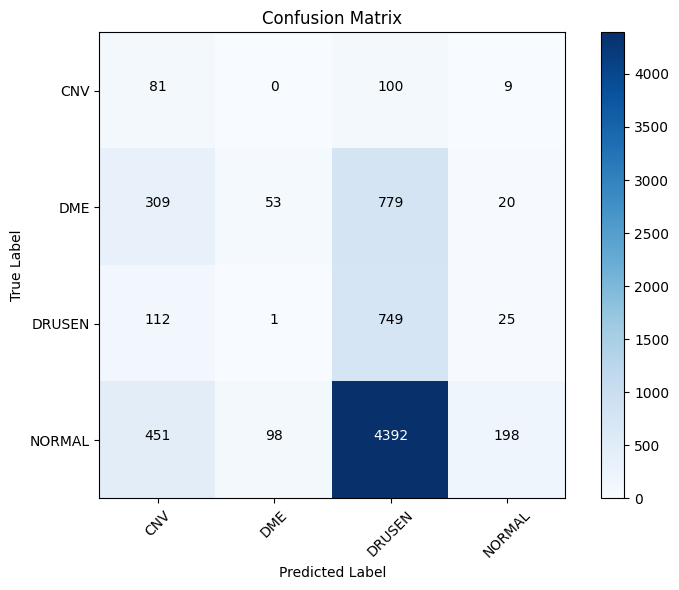

In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# Constants
img_height, img_width = 224, 224  # Input size for VGG16
batch_size = 32

# Directories
processed_data_dir = '/kaggle/input/processeddataset/processed_Dataset' 
test_dir = os.path.join(processed_data_dir, 'test')

# Data Generator for Test Set
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the saved model
model_path = '/kaggle/input/vgg16_best_model/keras/default/1/vgg16_best_model.keras'  
model = load_model(model_path)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict on the test set
y_true = test_generator.classes  # True labels
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted labels

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

class_names = list(test_generator.class_indices.keys())
plot_confusion_matrix(conf_matrix, class_names)
plt.show()


## fine-tuning model according to processed dataset

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt



In [2]:
# Constants
img_height, img_width = 224, 224  # Input size for VGG16
batch_size = 32
num_classes = 4  # Number of classes (CNV, DME, DRUSEN, NORMAL)
epochs = 20
learning_rate = 1e-4




In [3]:
# Paths
processed_data_dir = '/kaggle/input/processeddataset/processed_Dataset'
train_dir = f'{processed_data_dir}/train'
val_dir = f'{processed_data_dir}/val'
test_dir = f'{processed_data_dir}/test'


In [4]:
# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 9439 images belonging to 4 classes.
Found 613 images belonging to 4 classes.
Found 7377 images belonging to 4 classes.


In [5]:
# Load Pre-trained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

# Freeze the base model layers
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Add a custom classification head
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)  # Increased capacity
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate/10),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('/kaggle/working/vgg16_best_model_preprocessed.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [7]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, lr_scheduler],
    verbose=1
)


# Final Training and Validation Accuracy
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"\nFinal Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")

# Save the final model
model.save('/kaggle/working/vgg16_final_model_preprocessed.keras')

# Evaluate Test Accuracy
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732973938.160130     119 service.cc:145] XLA service 0x79d7c0002610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732973938.160195     119 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732973938.160200     119 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732973984.980074     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.2757 - loss: 1.4425
Epoch 1: val_accuracy improved from -inf to 0.66069, saving model to /kaggle/working/vgg16_best_model_preprocessed.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 312s 869ms/step - accuracy: 0.2759 - loss: 1.4419 - val_accuracy: 0.6607 - val_loss: 0.8531 - learning_rate: 1.0000e-05
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.4756 - loss: 0.9159
Epoch 2: val_accuracy improved from 0.66069 to 0.75204, saving model to /kaggle/working/vgg16_best_model_preprocessed.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 163s 543ms/step - accuracy: 0.4757 - loss: 0.9157 - val_accuracy: 0.7520 - val_loss: 0.6451 - learning_rate: 1.0000e-05
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.6234 - loss: 0.7029
Epoch 3: val_accuracy improved from 0.75204 to 0.81077, saving model to /kaggle/working/vgg16_best_model_preprocessed.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 163s 542ms/step - accuracy: 0.6235 - loss: 0.7028 -

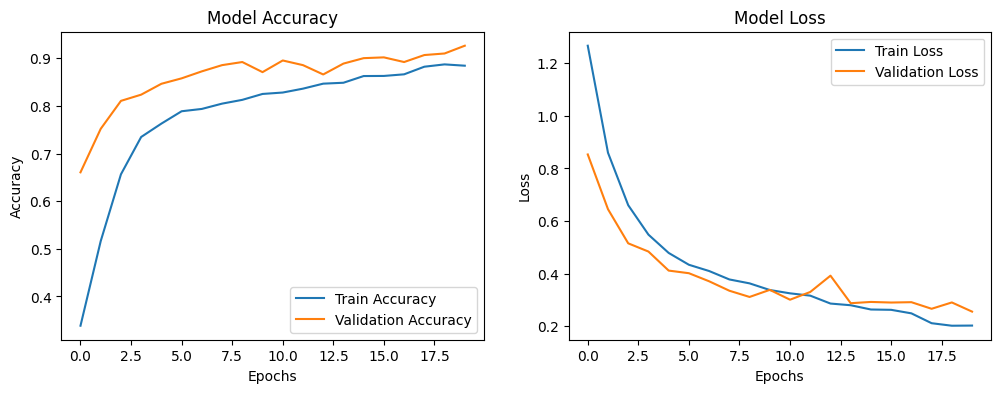

In [8]:
# Plot Training History
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

## ResNet50V 

### on raw dataset

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import matplotlib.pyplot as plt

In [11]:
# Constants
img_height, img_width = 224, 224  # Input size for ResNet50
batch_size = 32
num_classes = 4  # Number of classes: CNV, DME, DRUSEN, NORMAL
epochs = 20
learning_rate = 0.0001

# Paths
raw_data_dir = '/kaggle/input/oct-multiclass-analysis-4-class/Dataset - train+val+test'
train_dir = os.path.join(raw_data_dir, 'train')
val_dir = os.path.join(raw_data_dir, 'val')
test_dir = os.path.join(raw_data_dir, 'test')

In [12]:
# Data Generators with Augmentation for Raw Dataset
raw_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shearing transformation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True  # Horizontal flip
)

raw_train_generator = raw_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
raw_val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)
raw_test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 9439 images belonging to 4 classes.
Found 613 images belonging to 4 classes.
Found 7377 images belonging to 4 classes.


In [13]:
# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(raw_train_generator.classes),
    y=raw_train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Build ResNet50 Model
base_model_raw = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
# Fine-tune the top layers
for layer in base_model_raw.layers[-10:]:
    layer.trainable = True

# Add classification layers
x = base_model_raw.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)  # Additional dense layer
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer_raw = Dense(num_classes, activation='softmax')(x)

model_raw = Model(inputs=base_model_raw.input, outputs=output_layer_raw)


In [15]:
# Compile the model
model_raw.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate / 10),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Callbacks
checkpoint_raw = ModelCheckpoint('/kaggle/working/resnet50_best_raw.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping_raw = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
lr_scheduler_raw = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)



In [17]:
# Train the model
history_raw = model_raw.fit(
    raw_train_generator,
    validation_data=raw_val_generator,
    epochs=epochs,
    callbacks=[checkpoint_raw, early_stopping_raw, lr_scheduler_raw],
    class_weight=class_weights,
    verbose=1  # Ensure verbose mode to print logs
)
    
# Final Training and Validation Accuracy
train_accuracy = history_raw.history['accuracy'][-1]
val_accuracy = history_raw.history['val_accuracy'][-1]

print(f"\nFinal Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")

# Save the final model
model_raw.save('/kaggle/working/resnet50_final_raw.keras')

# Evaluate the model on the test dataset
test_loss, test_accuracy = model_raw.evaluate(raw_test_generator, verbose=1)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9676 - loss: 0.0751
Epoch 1: val_accuracy improved from 0.97390 to 0.98532, saving model to /kaggle/working/resnet50_best_raw.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 121s 401ms/step - accuracy: 0.9676 - loss: 0.0751 - val_accuracy: 0.9853 - val_loss: 0.0660 - learning_rate: 1.0000e-05
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9646 - loss: 0.0787
Epoch 2: val_accuracy did not improve from 0.98532
295/295 ━━━━━━━━━━━━━━━━━━━━ 119s 393ms/step - accuracy: 0.9646 - loss: 0.0787 - val_accuracy: 0.9772 - val_loss: 0.0737 - learning_rate: 1.0000e-05
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9657 - loss: 0.0705
Epoch 3: val_accuracy did not improve from 0.98532
295/295 ━━━━━━━━━━━━━━━━━━━━ 119s 392ms/step - accuracy: 0.9657 - loss: 0.0705 - val_accuracy: 0.9723 - val_loss: 0.1186 - learning_rate: 1.0000e-05
Epoch 4/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9643 - 

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
# Confusion Matrix and Classification Report
y_true = raw_test_generator.classes
y_pred = model_raw.predict(raw_test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

print("\nClassification Report:")
class_names = list(raw_test_generator.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_names))



231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step

Confusion Matrix:
[[ 182    1    7    0]
 [  32 1058   25   46]
 [  20    5  826   36]
 [  41   44  276 4778]]

Classification Report:
              precision    recall  f1-score   support

         CNV       0.66      0.96      0.78       190
         DME       0.95      0.91      0.93      1161
      DRUSEN       0.73      0.93      0.82       887
      NORMAL       0.98      0.93      0.96      5139

    accuracy                           0.93      7377
   macro avg       0.83      0.93      0.87      7377
weighted avg       0.94      0.93      0.93      7377



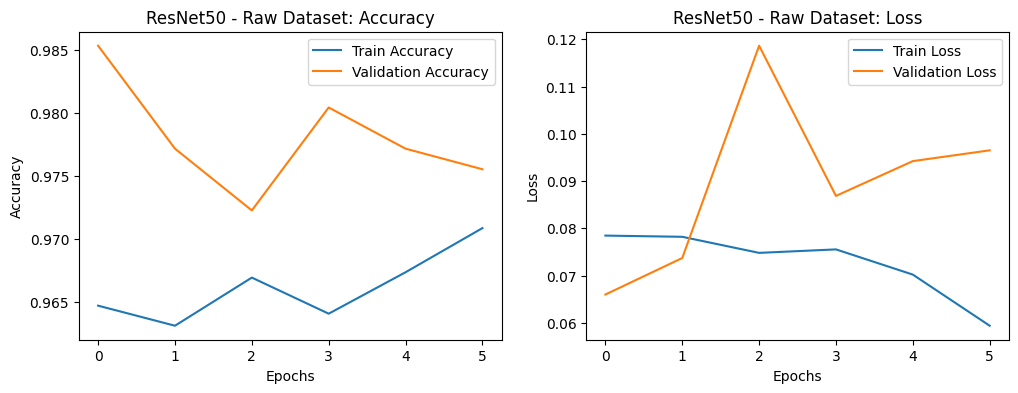

In [30]:
# Plot Training History
def plot_training_history_raw(history_raw):
    plt.figure(figsize=(12, 4))
# Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_raw.history['accuracy'], label='Train Accuracy')
    plt.plot(history_raw.history['val_accuracy'], label='Validation Accuracy')
    plt.title('ResNet50 - Raw Dataset: Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_raw.history['loss'], label='Train Loss')
    plt.plot(history_raw.history['val_loss'], label='Validation Loss')
    plt.title('ResNet50 - Raw Dataset: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history_raw(history_raw)


### on processed dataset

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import matplotlib.pyplot as plt




In [2]:
# Constants
img_height, img_width = 224, 224  # Input size for ResNet50
batch_size = 32
num_classes = 4
epochs = 20
learning_rate = 0.0001



In [3]:
# Paths
processed_data_dir = '/kaggle/input/processeddataset/processed_Dataset'
train_dir = os.path.join(processed_data_dir, 'train')
val_dir = os.path.join(processed_data_dir, 'val')
test_dir = os.path.join(processed_data_dir, 'test')



In [16]:
# Data Generators for Processed Dataset
proc_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

proc_train_generator = proc_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
proc_val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)
proc_test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 9439 images belonging to 4 classes.
Found 613 images belonging to 4 classes.
Found 7377 images belonging to 4 classes.


In [5]:
# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(proc_train_generator.classes),
    y=proc_train_generator.classes
)
class_weights = dict(enumerate(class_weights))



In [6]:
# Build ResNet50 Model
base_model_proc = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

# Fine-tune top layers of ResNet50
for layer in base_model_proc.layers[-10:]:
    layer.trainable = True



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Add classification layers
x = base_model_proc.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)  # Additional dense layer
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model_proc = Model(inputs=base_model_proc.input, outputs=output_layer)



In [8]:
# Compile the model
model_proc.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate / 10),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])



In [9]:
# Callbacks
checkpoint_proc = ModelCheckpoint('/kaggle/working/resnet50_best_processed.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping_proc = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
lr_scheduler_proc = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)



In [10]:
history_proc = model_proc.fit(
    proc_train_generator,
    validation_data=proc_val_generator,
    epochs=epochs,
    callbacks=[checkpoint_proc, early_stopping_proc, lr_scheduler_proc],
    class_weight=class_weights,
    verbose=1  # Ensure verbose mode to print logs
)
# Final Training and Validation Accuracy
train_accuracy = history_proc.history['accuracy'][-1]
val_accuracy = history_proc.history['val_accuracy'][-1]


print(f"\nFinal Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732770505.895940     114 service.cc:145] XLA service 0x7fe87c0030e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732770505.896000     114 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/295 ━━━━━━━━━━━━━━━━━━━━ 5:12:11 64s/step - accuracy: 0.3438 - loss: 1.5241

I0000 00:00:1732770536.244811     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.3205 - loss: 1.5790
Epoch 1: val_accuracy improved from -inf to 0.25122, saving model to /kaggle/working/resnet50_best_processed.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 264s 680ms/step - accuracy: 0.3206 - loss: 1.5785 - val_accuracy: 0.2512 - val_loss: 1.4777 - learning_rate: 1.0000e-05
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.4251 - loss: 1.0915
Epoch 2: val_accuracy improved from 0.25122 to 0.37847, saving model to /kaggle/working/resnet50_best_processed.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 119s 393ms/step - accuracy: 0.4252 - loss: 1.0913 - val_accuracy: 0.3785 - val_loss: 1.2557 - learning_rate: 1.0000e-05
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.5658 - loss: 0.8587
Epoch 3: val_accuracy improved from 0.37847 to 0.46656, saving model to /kaggle/working/resnet50_best_processed.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 119s 393ms/step - accuracy: 0.5659 - loss: 0.8585 - val_accuracy: 0.4

In [17]:
from tensorflow.keras.models import Model
# Save the final model
model_proc.save('/kaggle/working/resnet50_final_processed.keras')

# Evaluate Test Accuracy
test_loss, test_accuracy = model_proc.evaluate(proc_test_generator, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

231/231 ━━━━━━━━━━━━━━━━━━━━ 62s 268ms/step - accuracy: 0.7925 - loss: 0.5718

Test Loss: 0.6381
Test Accuracy: 76.01%


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
# Confusion Matrix and Classification Report
y_true = proc_test_generator.classes
y_pred = model_proc.predict(proc_test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

print("\nClassification Report:")
class_names = list(proc_test_generator.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_names))

231/231 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step

Confusion Matrix:
[[ 184    2    4    0]
 [  85  929   91   56]
 [  78   41  652  116]
 [  92  158 1047 3842]]

Classification Report:
              precision    recall  f1-score   support

         CNV       0.42      0.97      0.59       190
         DME       0.82      0.80      0.81      1161
      DRUSEN       0.36      0.74      0.49       887
      NORMAL       0.96      0.75      0.84      5139

    accuracy                           0.76      7377
   macro avg       0.64      0.81      0.68      7377
weighted avg       0.85      0.76      0.79      7377



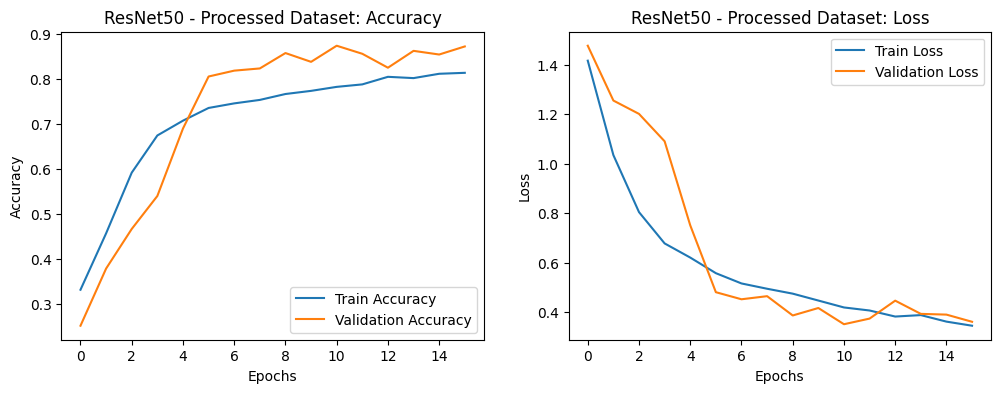

In [24]:
# Plot Training History
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('ResNet50 - Processed Dataset: Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('ResNet50 - Processed Dataset: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history_proc)

## Prediction

In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt




I0000 00:00:1733048189.891413     109 service.cc:145] XLA service 0x7b64c0005350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733048189.891484     109 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733048189.891492     109 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1733048192.832123     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


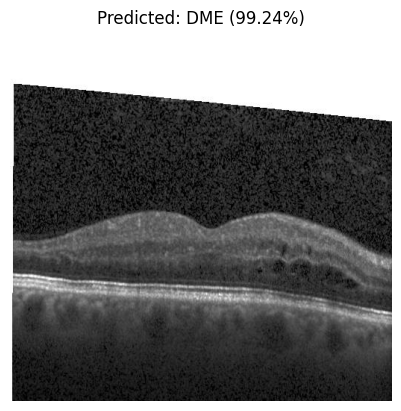

The predicted disease class is: DME


In [3]:
# Constants
img_height, img_width = 224, 224  # Input size for the model
class_labels = ['CNV', 'DME', 'DRUSEN', 'NORMAL']  # Update based on your dataset classes

# Load the best model
best_model_path = '/kaggle/input/vgg16_best_model/keras/default/1/vgg16_best_model.keras'  # Update path if using VGG16
model = load_model(best_model_path)

# Function to preprocess an image
def preprocess_image(image_path, target_size=(img_height, img_width)):
    """
    Preprocess an image for prediction.

    Args:
        image_path (str): Path to the image.
        target_size (tuple): Target size for resizing (width, height).

    Returns:
        np.array: Preprocessed image ready for prediction.
    """
    img = load_img(image_path, target_size=target_size)  # Load and resize image
    img_array = img_to_array(img)  # Convert to array
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to make predictions
def predict_disease(image_path, model, class_labels):
    """
    Predict the disease class for an image.

    Args:
        image_path (str): Path to the image.
        model (tf.keras.Model): Trained model for prediction.
        class_labels (list): List of class labels.

    Returns:
        str: Predicted disease class.
    """
    # Preprocess the image
    img_array = preprocess_image(image_path)

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions)

    # Display the image
    plt.imshow(load_img(image_path))
    plt.axis('off')
    plt.title(f"Predicted: {class_labels[predicted_class]} ({confidence * 100:.2f}%)")
    plt.show()

    return class_labels[predicted_class]

# Example usage
image_path = '/kaggle/input/oct-multiclass-analysis-4-class/Dataset - train+val+test/val/DME/DME-258763-41.jpeg'  # Update with your image path
predicted_class = predict_disease(image_path, model, class_labels)
print(f"The predicted disease class is: {predicted_class}")

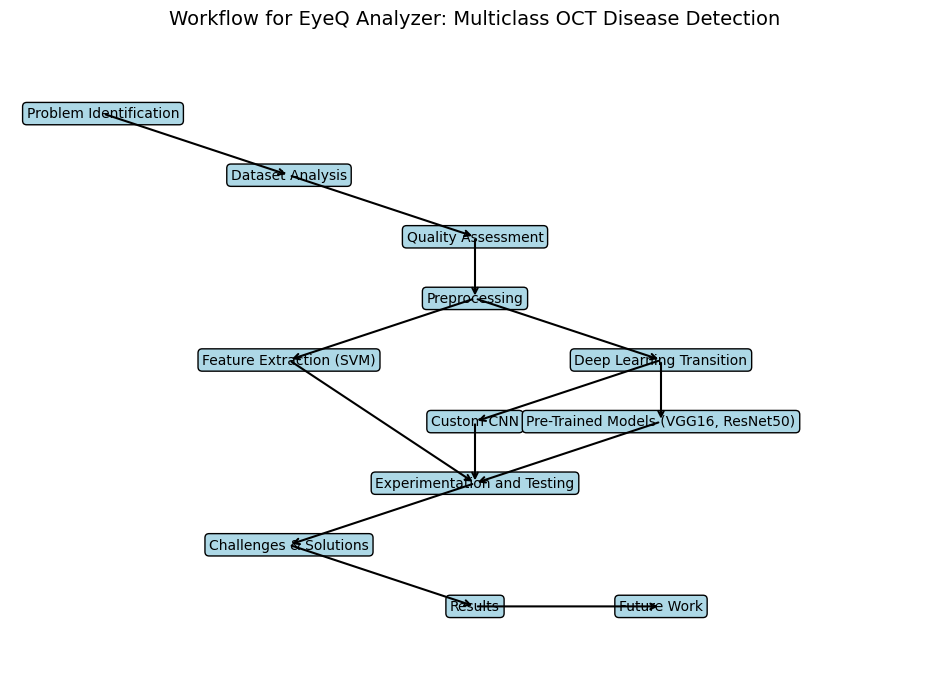

In [1]:
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey

# Create a figure for the flowchart
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')

# Define the flowchart elements as nodes
nodes = {
    "Problem Identification": (0.1, 0.9),
    "Dataset Analysis": (0.3, 0.8),
    "Quality Assessment": (0.5, 0.7),
    "Preprocessing": (0.5, 0.6),
    "Feature Extraction (SVM)": (0.3, 0.5),
    "Deep Learning Transition": (0.7, 0.5),
    "Custom CNN": (0.5, 0.4),
    "Pre-Trained Models (VGG16, ResNet50)": (0.7, 0.4),
    "Experimentation and Testing": (0.5, 0.3),
    "Challenges & Solutions": (0.3, 0.2),
    "Results": (0.5, 0.1),
    "Future Work": (0.7, 0.1),
}

# Define arrows (edges) between nodes
edges = [
    ("Problem Identification", "Dataset Analysis"),
    ("Dataset Analysis", "Quality Assessment"),
    ("Quality Assessment", "Preprocessing"),
    ("Preprocessing", "Feature Extraction (SVM)"),
    ("Preprocessing", "Deep Learning Transition"),
    ("Feature Extraction (SVM)", "Experimentation and Testing"),
    ("Deep Learning Transition", "Custom CNN"),
    ("Deep Learning Transition", "Pre-Trained Models (VGG16, ResNet50)"),
    ("Custom CNN", "Experimentation and Testing"),
    ("Pre-Trained Models (VGG16, ResNet50)", "Experimentation and Testing"),
    ("Experimentation and Testing", "Challenges & Solutions"),
    ("Challenges & Solutions", "Results"),
    ("Results", "Future Work"),
]

# Plot nodes as text and edges as arrows
for node, position in nodes.items():
    ax.text(position[0], position[1], node, ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightblue'))

for edge in edges:
    start = nodes[edge[0]]
    end = nodes[edge[1]]
    ax.annotate('', xy=end, xytext=start, arrowprops=dict(arrowstyle='->', lw=1.5))

# Display the flowchart
plt.title("Workflow for EyeQ Analyzer: Multiclass OCT Disease Detection", fontsize=14, pad=20)
plt.show()
